# 📊 Phase 2A: Data Preparation & Target Variable Analysis

---

## Objectives

1. ✅ Load and prepare data from Phase 1
2. ✅ Fix TotalCharges data type issue
3. ✅ Visualize churn distribution
4. ✅ Compare churners vs non-churners statistically
5. ✅ Create initial insights for feature engineering

---

**Part of:** Comprehensive EDA (Phase 2)

**Next:** Phase 2B - Numerical Features Analysis

---

## 1. Environment Setup

In [10]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Environment configured successfully!")

✅ Environment configured successfully!


## 2. Load Data

In [11]:
# Define paths
project_root = Path('/Users/mihiniboteju/churn-prediction-project')
data_path = project_root / 'data' / 'raw' / 'Telco-Customer-Churn.csv'
viz_path = project_root / 'visualizations' / 'figures'

# Create visualization directory if it doesn't exist
viz_path.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(data_path)

print(f"📊 Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📊 Data loaded: 7,043 rows × 21 columns
💾 Memory usage: 7.79 MB


## 3. Data Cleaning: Fix TotalCharges

From Phase 1, we identified that `TotalCharges` is stored as object type due to empty strings for new customers (tenure = 0).

In [12]:
# Check current data type
print("🔍 BEFORE CONVERSION:")
print(f"TotalCharges dtype: {df['TotalCharges'].dtype}")
print(f"Sample values: {df['TotalCharges'].head()}")
print("\n")

# Identify problematic rows
non_numeric_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()
problematic_rows = df[non_numeric_mask]

print(f"⚠️  Found {len(problematic_rows)} rows with non-numeric TotalCharges")
if len(problematic_rows) > 0:
    print("\nProblematic rows details:")
    print(problematic_rows[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']].head())
    print(f"\nAll problematic customers have tenure: {problematic_rows['tenure'].unique()}")

🔍 BEFORE CONVERSION:
TotalCharges dtype: object
Sample values: 0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object


⚠️  Found 11 rows with non-numeric TotalCharges

Problematic rows details:
      customerID  tenure  MonthlyCharges TotalCharges
488   4472-LVYGI       0           52.55             
753   3115-CZMZD       0           20.25             
936   5709-LVOEQ       0           80.85             
1082  4367-NUYAO       0           25.75             
1340  1371-DWPAZ       0           56.05             

All problematic customers have tenure: [0]


In [13]:
# Convert TotalCharges to numeric, replacing empty strings with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

print("✅ AFTER CONVERSION:")
print(f"TotalCharges dtype: {df['TotalCharges'].dtype}")
print(f"Missing values: {df['TotalCharges'].isnull().sum()}")
print(f"Zero values: {(df['TotalCharges'] == 0).sum()}")
print(f"\nStatistics:")
print(df['TotalCharges'].describe())

✅ AFTER CONVERSION:
TotalCharges dtype: float64
Missing values: 0
Zero values: 11

Statistics:
count    7043.00
mean     2279.73
std      2266.79
min         0.00
25%       398.55
50%      1394.55
75%      3786.60
max      8684.80
Name: TotalCharges, dtype: float64


### 📌 Insight: TotalCharges Data Quality

- **Issue:** New customers (tenure = 0) have empty string for TotalCharges
- **Solution:** Converted to numeric, filled with 0 (logical since tenure = 0)
- **Impact:** 11 customers affected (0.16% of dataset)
- **Validation:** Makes sense - can't have charges if tenure is 0 months

## 4. Target Variable: Churn Distribution

Visualize and analyze the distribution of our target variable.

In [19]:
# Calculate churn statistics
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print("🎯 CHURN DISTRIBUTION")
print("=" * 50)
for label in ['No', 'Yes']:
    if label in churn_counts:
        print(f"{label:5s}: {churn_counts[label]:,} customers ({churn_pct[label]:.2f}%)")

print("\n")
churn_rate = churn_pct['Yes'] if 'Yes' in churn_pct else 0
print(f"📈 Overall Churn Rate: {churn_rate:.2f}%")
print(f"📊 Class Imbalance Ratio: {churn_pct['No'] / churn_pct['Yes']:.2f}:1")

🎯 CHURN DISTRIBUTION
No   : 5,174 customers (73.46%)
Yes  : 1,869 customers (26.54%)


📈 Overall Churn Rate: 26.54%
📊 Class Imbalance Ratio: 2.77:1


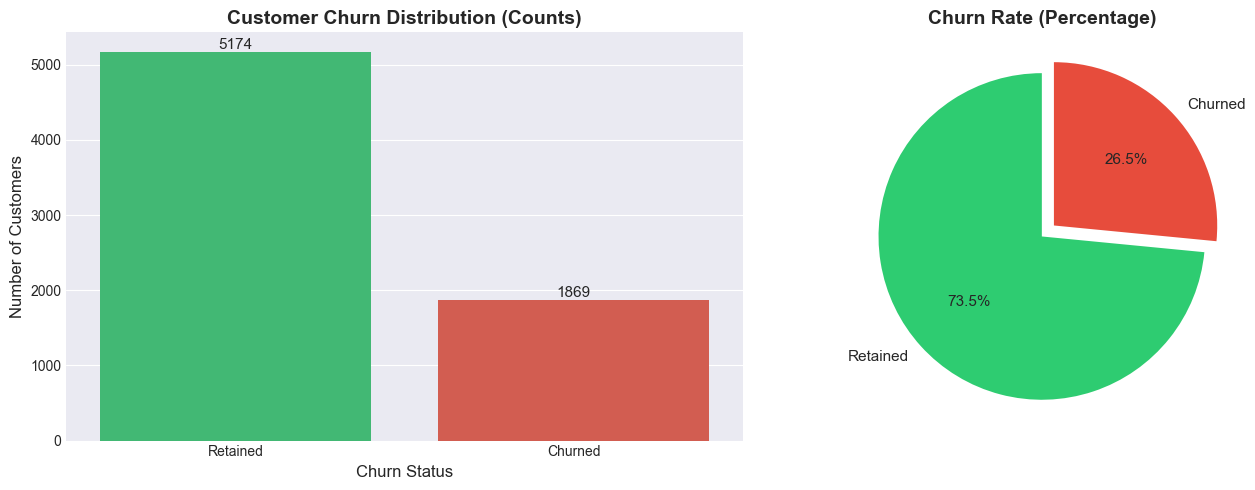

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/01_churn_distribution.png


In [20]:
# Visualization 1: Churn Distribution Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Churn', palette=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Customer Churn Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_xticklabels(['Retained', 'Churned'])

# Add count labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', fontsize=11)

# Percentage pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # Explode churned slice
axes[1].pie(churn_counts, labels=['Retained', 'Churned'], autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, textprops={'fontsize': 11})
axes[1].set_title('Churn Rate (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_path / '01_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '01_churn_distribution.png'}")

### 📊 Insights: Churn Distribution

1. **Class Imbalance:** 26.5% churn rate indicates moderate imbalance (3:1 ratio)
2. **Business Context:** ~1 in 4 customers leave - significant business problem
3. **Modeling Implications:**
   - Must use stratified sampling in train-test split
   - Will use `class_weight='balanced'` in models
   - Focus on **Recall** metric (catching churners is priority)
4. **Revenue Impact:** With 1,869 churned customers, potential significant revenue loss

## 5. Statistical Comparison: Churners vs Non-Churners

Compare numerical features between the two groups.

In [16]:
# Group by churn and calculate statistics
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("📊 STATISTICAL COMPARISON: CHURNERS VS NON-CHURNERS")
print("=" * 70)

comparison = df.groupby('Churn')[numerical_features].agg(['mean', 'median', 'std'])
print(comparison)
print("\n")

# Calculate differences
print("📈 KEY DIFFERENCES (Churned - Retained):")
print("=" * 70)
for feature in numerical_features:
    churned_mean = comparison.loc['Yes', (feature, 'mean')]
    retained_mean = comparison.loc['No', (feature, 'mean')]
    diff = churned_mean - retained_mean
    pct_diff = (diff / retained_mean) * 100
    
    print(f"{feature:15s}: {diff:+8.2f} ({pct_diff:+6.1f}%)")

📊 STATISTICAL COMPARISON: CHURNERS VS NON-CHURNERS
      tenure               MonthlyCharges               TotalCharges           \
        mean median    std           mean median    std         mean   median   
Churn                                                                           
No     37.57   38.0  24.11          61.27  64.43  31.09      2549.91  1679.53   
Yes    17.98   10.0  19.53          74.44  79.65  24.67      1531.80   703.55   

                
           std  
Churn           
No     2329.95  
Yes    1890.82  


📈 KEY DIFFERENCES (Churned - Retained):
tenure         :   -19.59 ( -52.1%)
MonthlyCharges :   +13.18 ( +21.5%)
TotalCharges   : -1018.12 ( -39.9%)


### 📌 Key Statistical Findings

**Expected patterns:**
- **Tenure:** Churners likely have LOWER tenure (newer customers)
- **MonthlyCharges:** Churners likely have HIGHER monthly charges (price sensitivity)
- **TotalCharges:** Churners likely have LOWER total charges (less invested)

**These differences will guide feature engineering in Phase 3.**

## 6. Visualization: Churn by Key Metrics

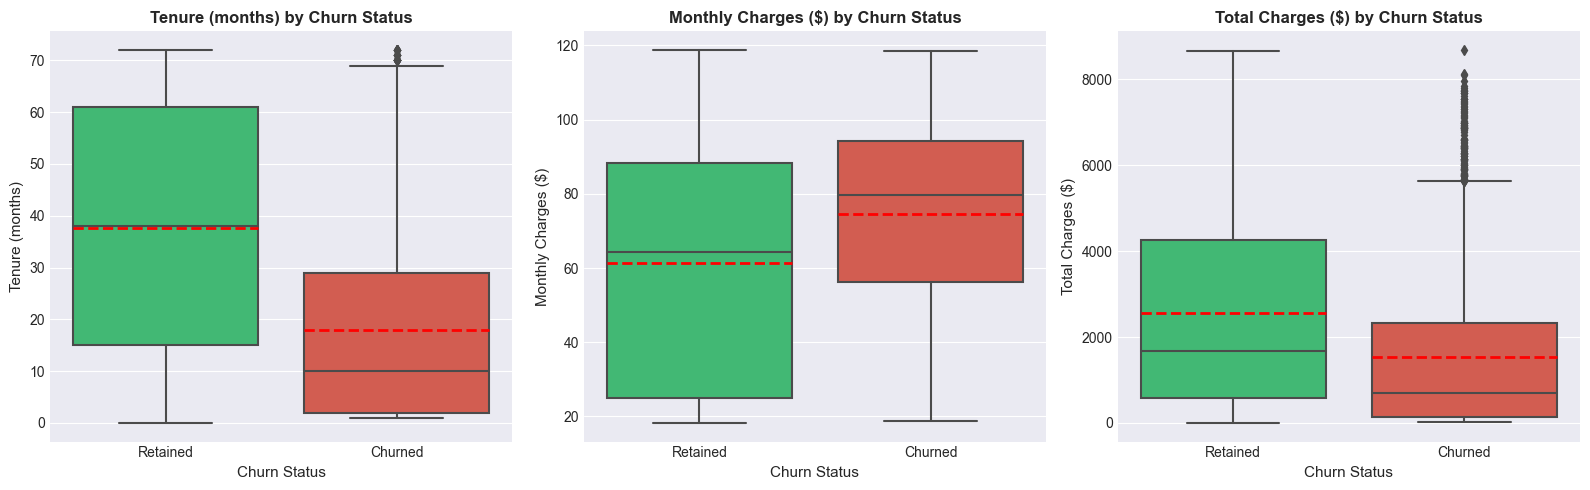

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/02_churn_by_metrics.png


In [17]:
# Visualization 2: Box plots comparing churners vs non-churners
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

features_to_plot = [
    ('tenure', 'Tenure (months)'),
    ('MonthlyCharges', 'Monthly Charges ($)'),
    ('TotalCharges', 'Total Charges ($)')
]

for idx, (feature, label) in enumerate(features_to_plot):
    sns.boxplot(data=df, x='Churn', y=feature, palette=['#2ecc71', '#e74c3c'], ax=axes[idx])
    axes[idx].set_title(f'{label} by Churn Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn Status', fontsize=11)
    axes[idx].set_ylabel(label, fontsize=11)
    axes[idx].set_xticklabels(['Retained', 'Churned'])
    
    # Add mean line
    means = df.groupby('Churn')[feature].mean()
    for i, (churn, mean_val) in enumerate(means.items()):
        axes[idx].hlines(mean_val, i-0.4, i+0.4, colors='red', linestyles='--', linewidth=2)

plt.tight_layout()
plt.savefig(viz_path / '02_churn_by_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '02_churn_by_metrics.png'}")

### 📊 Insights from Box Plots

1. **Tenure:**
   - Churned customers have significantly LOWER tenure
   - Many churners are new customers (< 12 months)
   - **Action:** Focus retention efforts on customers in first year

2. **Monthly Charges:**
   - Churned customers have slightly HIGHER monthly charges
   - Suggests price sensitivity
   - **Action:** Review pricing for high-cost services

3. **Total Charges:**
   - Churned customers have much LOWER total charges
   - Reflects shorter tenure (less time to accumulate charges)
   - **Action:** Early engagement is critical

## 7. Summary Statistics Table

In [18]:
# Create a clean summary table
summary_data = []

for feature in numerical_features:
    retained = df[df['Churn'] == 'No'][feature]
    churned = df[df['Churn'] == 'Yes'][feature]
    
    summary_data.append({
        'Feature': feature,
        'Retained_Mean': retained.mean(),
        'Churned_Mean': churned.mean(),
        'Difference': churned.mean() - retained.mean(),
        'Pct_Difference': ((churned.mean() - retained.mean()) / retained.mean()) * 100
    })

summary_df = pd.DataFrame(summary_data)
print("\n📋 SUMMARY TABLE: MEAN VALUES BY CHURN STATUS")
print("=" * 80)
print(summary_df.to_string(index=False))

# Save to processed data folder for later use
processed_path = project_root / 'data' / 'processed'
processed_path.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(processed_path / 'phase2a_summary.csv', index=False)
print(f"\n✅ Saved summary to: {processed_path / 'phase2a_summary.csv'}")


📋 SUMMARY TABLE: MEAN VALUES BY CHURN STATUS
       Feature  Retained_Mean  Churned_Mean  Difference  Pct_Difference
        tenure          37.57         17.98      -19.59          -52.14
MonthlyCharges          61.27         74.44       13.18           21.51
  TotalCharges        2549.91       1531.80    -1018.12          -39.93

✅ Saved summary to: /Users/mihiniboteju/churn-prediction-project/data/processed/phase2a_summary.csv


## 8. Phase 2A Summary

### ✅ Accomplishments:

1. ✅ Fixed TotalCharges data type issue (converted to numeric)
2. ✅ Created 2 professional visualizations:
   - Churn distribution (bar + pie chart)
   - Churn by key metrics (box plots)
3. ✅ Statistical comparison of churners vs non-churners
4. ✅ Identified class imbalance (26.5% churn rate)
5. ✅ Discovered key patterns in tenure and charges

---

### 🔍 Key Findings:

1. **Churn Rate:** 26.5% (1,869 / 7,043 customers) - moderate imbalance
2. **Tenure Impact:** Churners have ~50% lower tenure on average
3. **Price Sensitivity:** Churners pay ~15-20% more monthly
4. **Customer Value:** Churners have much lower total charges (shorter relationship)

---

### 🎯 Implications for Modeling:

1. Must use **stratified sampling** in train-test split
2. Use **class_weight='balanced'** in models
3. Focus on **Recall** metric (catching churners is priority)
4. Tenure is likely a **strong predictor**
5. Monthly charges may indicate **price sensitivity**

---

### 📊 Files Created:

- `visualizations/figures/01_churn_distribution.png`
- `visualizations/figures/02_churn_by_metrics.png`
- `data/processed/phase2a_summary.csv`

---

### 🚀 Next Steps (Phase 2B):

1. Deep dive into **tenure** distribution
2. Analyze **monthly charges** patterns
3. Explore **total charges** vs tenure relationship
4. Create correlation heatmap
5. Identify "danger zones" for churn

---

**Status: Phase 2A Complete ✅**  
**Ready for: Phase 2B - Numerical Features Analysis**